# 03 - Adversarial Attacks (FGSM)

**Goal:** Generate adversarial examples using FGSM and extract features for TDA analysis

### Overview
In this notebook, we will:
1. Build a simple CIFAR-10 classifier
2. Generate FGSM adversarial examples
3. Visualize clean vs adversarial images
4. Extract features from adversarial images
5. Compare clean vs adversarial feature distributions

**Why FGSM?**
- Fast and simple adversarial attack
- Creates imperceptible perturbations
- Good starting point for adversarial robustness analysis

### Setup and Imports

In [41]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from src.data.cifar10 import load_cifar10
from src.models.feature_extractor import FeatureExtractor, DimensionalityReducer
from src.attacks.fgsm import FGSMAttack, generate_fgsm_dataset

np.random.seed(111)       # For reproducibility
tf.random.set_seed(111)

print("Successfully imported everything")

Successfully imported everything


### Load the CIFAR-10 Dataset

In [17]:
(training_images, training_labels), (validation_images, validation_labels), (testing_images, testing_labels), class_names = load_cifar10(validation_split=0.1)

# Verify:
print(f"\nUsing {len(training_images)} samples")
print(f"Image shape: {training_images.shape}")
print(f"Label shape: {training_labels.shape}")


Final splits:
Training:   45000 samples
Validation: 5000 samples
Testing:    10000 samples

Using 45000 samples
Image shape: (45000, 32, 32, 3)
Label shape: (45000,)


### Build the CIFAR-10 Classifier

We'll create a simple CNN to classify CIFAR-10 images. This will be our "victim model" that we'll attack later

In [18]:
def build_cifar10_classifier():
    """
    Simple CNN for CIFAR-10 classification.
    ~92% accuracy after training.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32,32,3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),         # Prevent overfitting
        # 16x16x32
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        # 8x8x64
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        # 4x4x128
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier = build_cifar10_classifier()
print("CIFAR-10 Classifier summary: ")
classifier.summary()

CIFAR-10 Classifier summary: 


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,201,418 (8.40 MB)

 Trainable params: 2,199,114 (8.39 MB)

 Non-trainable params: 2,304 (9.00 KB)

### Train the Classifier

We'll train for just 10 epochs to get a decent accuracy. This is enough to demonstrate adversarial attacks:

In [19]:
history = classifier.fit(
    training_images,
    training_labels,
    epochs=15,
    batch_size=128,
    validation_data=(validation_images[:1000], validation_labels[:1000]),
    verbose=1
)

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 134s 350ms/step - accuracy: 0.4708 - loss: 1.6030 - val_accuracy: 0.2370 - val_loss: 2.2708
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 128s 363ms/step - accuracy: 0.6694 - loss: 0.9511 - val_accuracy: 0.6830 - val_loss: 0.8887
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 113s 320ms/step - accuracy: 0.7458 - loss: 0.7318 - val_accuracy: 0.7180 - val_loss: 0.8934
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 122s 348ms/step - accuracy: 0.7943 - loss: 0.6011 - val_accuracy: 0.7820 - val_loss: 0.6616
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 117s 332ms/step - accuracy: 0.8258 - loss: 0.5049 - val_accuracy: 0.7790 - val_loss: 0.6906
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 117s 332ms/step - accuracy: 0.8524 - loss: 0.4295 - val_accuracy: 0.7970 - val_loss: 0.6490
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.8746 - loss: 0.3630 - val_accuracy: 0.8070 - val_loss: 0.5917
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.8902 -

### Evaluate Classifier on Clean Images

In [42]:
# Evaluate on test set
test_loss, test_accuracy = classifier.evaluate(
    testing_images[:1000],
    testing_labels[:1000],
    verbose=0
)

print("Classifier Performance on Clean Images:")
print(f"Test accuracy: {test_accuracy:.2%}")
print(f"Test loss:     {test_loss:.4f}")

Classifier Performance on Clean Images:
Test accuracy: 82.50%
Test loss:     0.6585


### Generate FGSM Adversarial Examples

Now we'll attack our trained classifier using FGSM with $ε$ = 0.03

In [43]:
epsilon = 0.03
attacker = FGSMAttack(classifier, epsilon=epsilon)

# Generate adversarial examples for subset
print(f"\nGenerating FGSM adversarial examples (ε={epsilon})")
fgsm_images, fgsm_success_rate = generate_fgsm_dataset(
    classifier,
    training_images,
    training_labels,
    epsilon=epsilon,
    batch_size=128,
    verbose=True
)

print(f"\nGenerated {len(fgsm_images):,} adversarial examples")
print(f"Attack success rate: {fgsm_success_rate:.2%}")

FGSM Attack successfully initialized
Epsilon: 0.03

Generating FGSM adversarial examples (ε=0.03)
FGSM Attack successfully initialized
Epsilon: 0.03


Generating FGSM attacks: 100%|██████████| 352/352 [02:18<00:00,  2.54it/s]



FGSM dataset complete
Total samples: 45000
Average attack success rate: 92.48%

Generated 45,000 adversarial examples
Attack success rate: 92.48%


### Visualize Clean vs Adversarial Images

Let's see how the adversarial examples look compared to clean images:

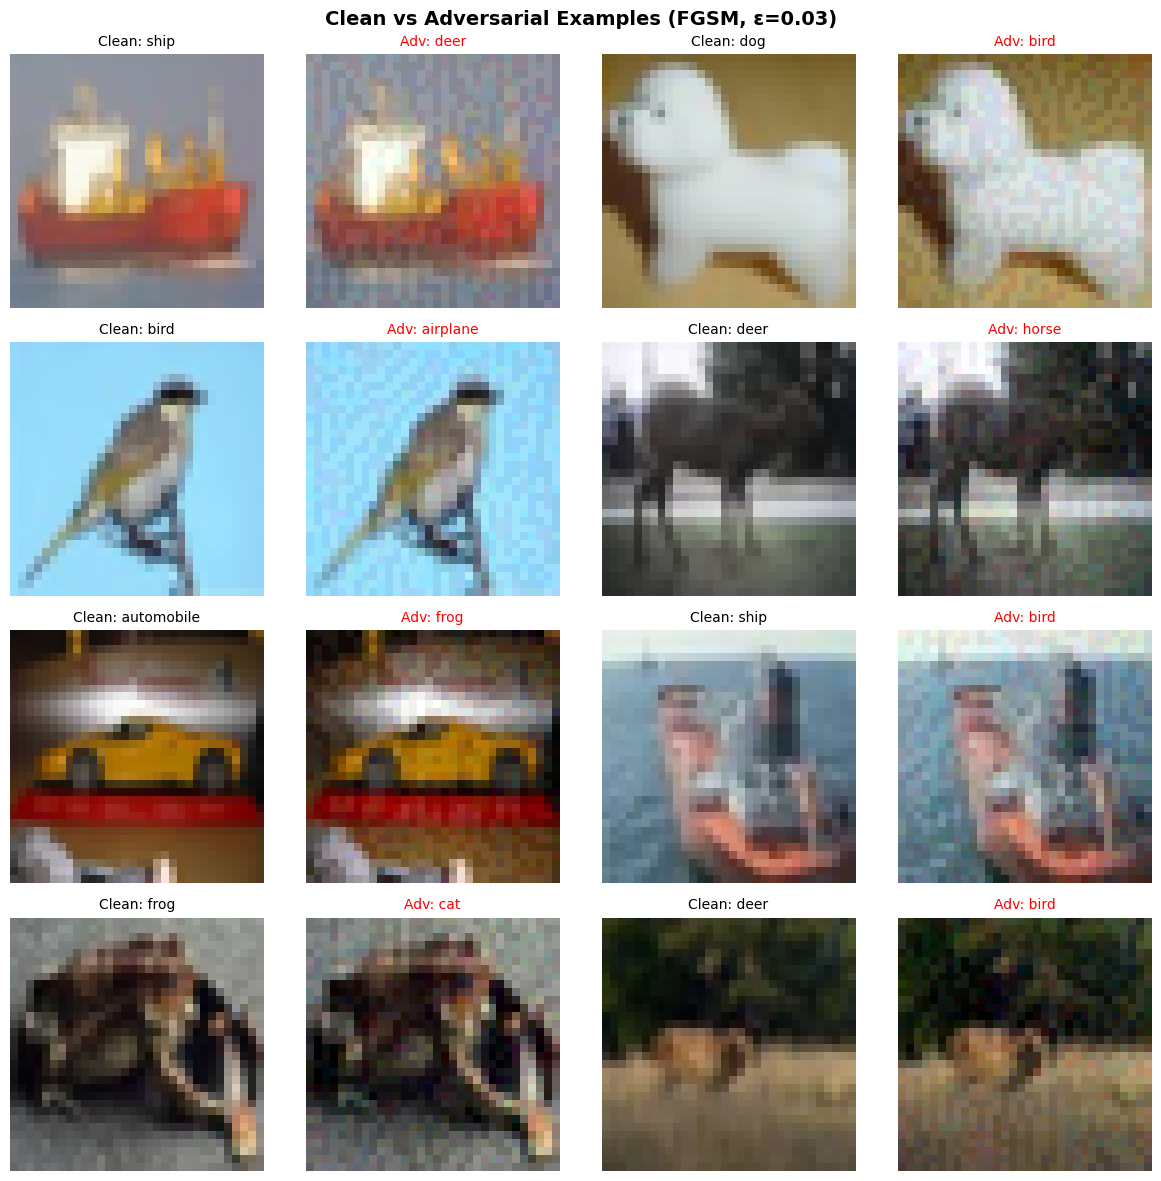

Saved in results/figures/03_fgsm_examples.png


In [44]:
np.random.seed(111)
sample_indices = np.random.choice(len(training_images), 8, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, idx in enumerate(sample_indices):
    # Clean image on left column
    ax_clean = axes[i, 0] if i < 4 else axes[i-4, 2]
    ax_clean.imshow(training_images[idx])
    ax_clean.set_title(f"Clean: {class_names[training_labels[idx]]}", fontsize=10)
    ax_clean.axis('off')
    
    # Adversarial image on right column
    if i < 4:
        ax_adv = axes[i, 1]
    else:
        ax_adv = axes[i-4, 3]
    ax_adv.imshow(fgsm_images[idx])
    
    # Predict adversarial label
    adv_pred = classifier.predict(fgsm_images[idx:idx+1], verbose=0).argmax()
    ax_adv.set_title(f"Adv: {class_names[adv_pred]}", fontsize=10, color='red')
    ax_adv.axis('off')

plt.suptitle(f'Clean vs Adversarial Examples (FGSM, ε={epsilon})', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../results/figures/03_fgsm_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved in results/figures/03_fgsm_examples.png")

### Visualize Perturbations

Let's see the actual perturbations added by FGSM (magnified for visibility):

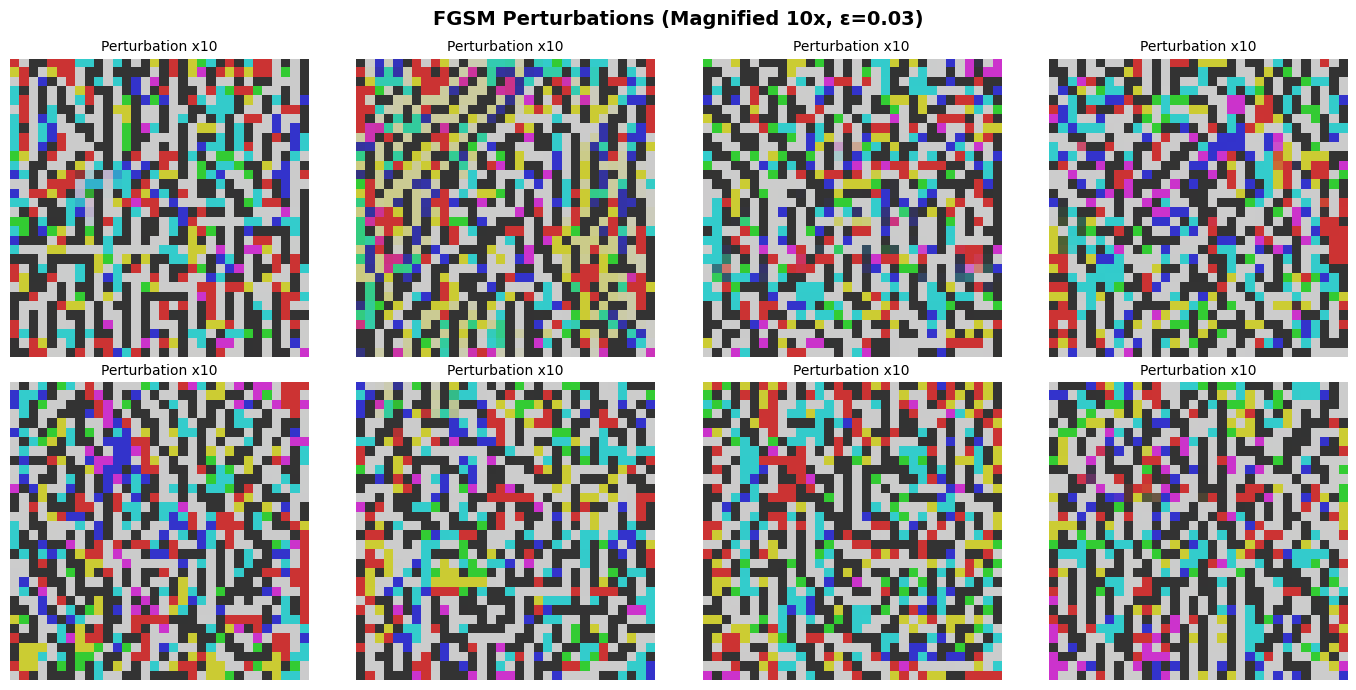

Saved in results/figures/03_fgsm_perturbations.png


In [45]:
perturbations = fgsm_images - training_images     # Noise that FGSM added

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()
for i, idx in enumerate(sample_indices):
    pert_magnified = np.clip(perturbations[idx] * 10 + 0.5, 0, 1)
    axes[i].imshow(pert_magnified)
    axes[i].set_title(f"Perturbation x10", fontsize=10)
    axes[i].axis('off')

plt.suptitle(f'FGSM Perturbations (Magnified 10x, ε={epsilon})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/03_fgsm_perturbations.png', bbox_inches='tight')
plt.show()

print("Saved in results/figures/03_fgsm_perturbations.png")

### Extract Features from Adversarial Images

Now let's extract ResNet50 features from the adversarial examples, just like we did for clean images:

In [46]:
extractor = FeatureExtractor(model_name='resnet50')

# Extract features from FGSM adversarial images:
fgsm_features_original = extractor.extract_features(
    fgsm_images,
    batch_size=64,
    verbose=True
)

print(f"\nSuccessfully extracted adversarial features: {fgsm_features_original.shape}")


Model: resnet50
Feature dimension: 2048
Total parameters: 23,587,712



Feature extraction in progress... : 100%|██████████| 704/704 [14:11<00:00,  1.21s/batch]



Extracted features from 45,000 images
Feature shape: (45000, 2048)
Feature range: [0.000, 17.505]

Successfully extracted adversarial features: (45000, 2048)


### Apply PCA to Adversarial Features

Let' use dimensionality reduction using the **same PCA transformation** we fit on clean data:

In [47]:
clean_features_original, clean_labels = FeatureExtractor.load_features('../results/features/clean_features_original.npz')
print(f"Loaded clean features: {clean_features_original.shape}")

reducer = DimensionalityReducer(n_components=50, random_state=111)    # Fit PCA on clean features
clean_features_reduced = reducer.fit_transform(clean_features_original, verbose=True)

print("\nTransforming adversarial features...")                      # Transform adversarial features using same PCA
fgsm_features_reduced = reducer.transform(fgsm_features_original)

print(f"Adversarial features reduced: {fgsm_features_reduced.shape}")

Loaded ../results/features/clean_features_original.npz — features: (45000, 2048), labels: (45000,)
Loaded clean features: (45000, 2048)

Applying PCA...
Original feature dimension: 2048
Target dimension: 50

Transforming adversarial features...
Adversarial features reduced: (45000, 50)


### Save Adversarial Features

In [48]:
# Save FGSM features (original 2048-dim)
extractor.save_features(
    fgsm_features_original,
    training_labels,
    '../results/features/fgsm_features_original.npz'
)

# Save FGSM features (reduced 50-dim)
np.savez_compressed(
    '../results/features/fgsm_features_reduced.npz',
    features=fgsm_features_reduced,
    labels=training_labels,
    epsilon=epsilon
)
print("Features saved to ../results/features/fgsm_features_reduced.npz")

Features saved to ../results/features/fgsm_features_original.npz
Features saved to ../results/features/fgsm_features_reduced.npz


### Compare Feature Distributions

Let's visualize how adversarial perturbations affect the feature space:

In [49]:
print("-----Feature space comparison-----")
print("\nClean Features (50-dim):")
print(f"Mean:   {clean_features_reduced.mean():.4f}")
print(f"Std:    {clean_features_reduced.std():.4f}")
print(f"Range:  [{clean_features_reduced.min():.2f}, {clean_features_reduced.max():.2f}]")

print("\nFGSM Adversarial Features (50-dim):")
print(f"Mean:   {fgsm_features_reduced.mean():.4f}")
print(f"Std:    {fgsm_features_reduced.std():.4f}")
print(f"Range:  [{fgsm_features_reduced.min():.2f}, {fgsm_features_reduced.max():.2f}]")

feature_diff = np.abs(clean_features_reduced - fgsm_features_reduced)
print("\nFeature Difference:")
print(f"Mean absolute difference: {feature_diff.mean():.4f}")
print(f"Max absolute difference:  {feature_diff.max():.4f}")

-----Feature space comparison-----

Clean Features (50-dim):
Mean:   0.0000
Std:    0.0745
Range:  [-2.48, 1.61]

FGSM Adversarial Features (50-dim):
Mean:   -0.0013
Std:    0.0751
Range:  [-2.44, 1.61]

Feature Difference:
Mean absolute difference: 0.0078
Max absolute difference:  0.1299


### t-SNE Visualization: Clean vs Adversarial

Compare how clean and adversarial examples distribute in feature space:

In [53]:
# Let's pick a subset for faster t-SNE:
n_vis = 2000
combined_features = np.vstack([
    clean_features_reduced[:n_vis],
    fgsm_features_reduced[:n_vis]
])

# Create labels (0 = clean, 1 = adversarial)
attack_labels = np.concatenate([np.zeros(n_vis),np.ones(n_vis)])

print(f"Computing t-SNE on {len(combined_features)} samples......")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(combined_features)
print("t-SNE complete")

Computing t-SNE on 4000 samples......
t-SNE complete


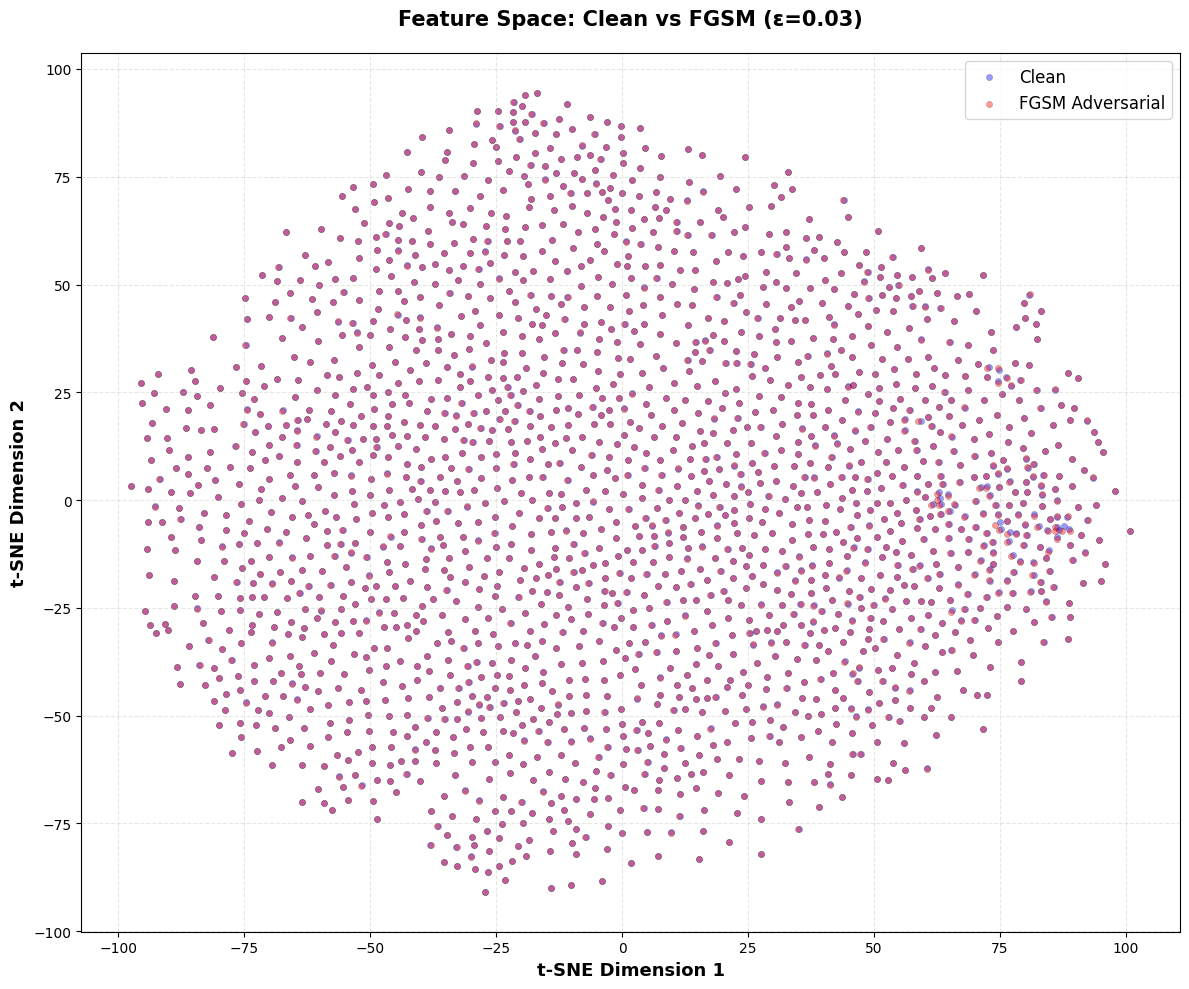

Saved in results/figures/03_tsne_clean_vs_fgsm.png


In [54]:
fig, ax = plt.subplots(figsize=(12, 10))    # t-SNE

# ---- clean = blue & adversarial = red ----
clean_mask = (attack_labels == 0)
adv_mask = (attack_labels == 1)

ax.scatter(
    features_2d[clean_mask, 0],
    features_2d[clean_mask, 1],
    c='blue',
    alpha=0.4,
    s=20,
    label='Clean',
    edgecolors='black',
    linewidth=0.3
)

ax.scatter(
    features_2d[adv_mask, 0],
    features_2d[adv_mask, 1],
    c='red',
    alpha=0.4,
    s=20,
    label='FGSM Adversarial',
    edgecolors='black',
    linewidth=0.3
)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title(f'Feature Space: Clean vs FGSM (ε={epsilon})', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/03_tsne_clean_vs_fgsm.png', bbox_inches='tight')
plt.show()

print("Saved in results/figures/03_tsne_clean_vs_fgsm.png")

### Summary

Adversarial attack generation is complete! Here's a quick recap of the things we did:

In [ ]:
print(f"Built CIFAR-10 classifier ({test_accuracy:.2%} clean accuracy)")
print(f"Generated {len(fgsm_images):,} FGSM adversarial examples")
print(f"Attack success rate: {fgsm_success_rate:.2%}")
print(f"Extracted 2048-dim features from adversarial images")
print(f"Reduced to 50-dim with PCA")

print("\nGenerated Files:")
print("fgsm_features_original.npz")
print("fgsm_features_reduced.npz")

print("\nGenerated Figures:")
print("03_fgsm_examples.png")
print("03_fgsm_perturbations.png")
print("03_tsne_clean_vs_fgsm.png")

print("\nNext Steps (PGD Attack):")
print("Implement PGD (stronger attack)")
print("Generate PGD adversarial examples")
print("Compare FGSM vs PGD")